# Active Directory structure analysis using Bloodhound graphs
* This code is inspired by the wonderful article "Jupyter Notebooks for BloodHound Analytics and Alternative Visualizations" written by Roberto Rodriguez. avilible at https://medium.com/threat-hunters-forge/jupyter-notebooks-for-bloodhound-analytics-and-alternative-visualizations-9543c2df576a
* Most of the Checking varibles are followed "Active Directory : Design Considerations and Best Practices" written by Subhro Majumder. avilible at https://social.technet.microsoft.com/wiki/contents/articles/52587.active-directory-design-considerations-and-best-practices.aspx

Guochao Sun
<br>
Unversity of Adelaide

In [1]:
from py2neo import Graph
import matplotlib.pyplot as plt
g = Graph("bolt://localhost:7687", auth=("neo4j", "mima:789"))
g

Graph('bolt://localhost:7687')

# 1. General information about the active directory

In [2]:
#Count total number of each types of nodes
num_nodes = g.run("""MATCH (n)RETURN count(n) as count""").to_data_frame()
num_Groups = g.run("""MATCH (n:Group)RETURN count(n) as count""").to_data_frame()
num_users = g.run("""MATCH (n:User)RETURN count(n) as count""").to_data_frame()
num_computers = g.run("""MATCH (n:Computer)RETURN count(n) as count""").to_data_frame()
num_OUs = g.run("""MATCH (n:OU)RETURN count(n) as count""").to_data_frame()
num_GPO = g.run("""MATCH (n:GPO)RETURN count(n) as count""").to_data_frame()
num_edges = g.run("""MATCH (n)-[r]->() RETURN COUNT(r) as count""").to_data_frame()

In [3]:
import pandas as pd
nodes = ['Groups', 'Users', 'Computers', 'OUs','GPO','Number of Nodes','Number of edges']
DA_info = pd.concat([num_Groups, num_users,num_computers,num_OUs,num_GPO,num_nodes,num_edges])
DA_info=DA_info.set_index([nodes])
DA_info

,count
Groups,1008
Users,1001
Computers,1001
OUs,21
GPO,22
Number of Nodes,3053
Number of edges,18980


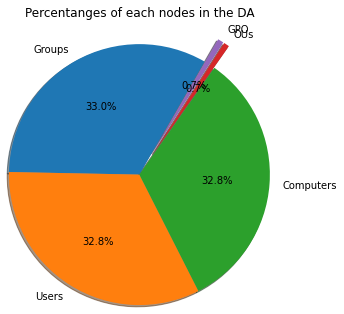

In [4]:
DA_info['count'][0:5].plot.pie(autopct='%.1f%%',labels=nodes[0:5],
                               shadow=True,fontsize=10,radius=1.5,explode = (0, 0, 0, 0.3,0.3),startangle=60)
plt.title("Percentanges of each nodes in the DA",y=1.2)
plt.ylabel('')
plt.show()

# 2. Computers

In [5]:
# Count the number of operating system
PC_OS = g.run ("""
MATCH (p:Computer)
UNWIND p.operatingsystem AS OS_type
RETURN OS_type, count(p)as count
""").to_data_frame()
PC_OS

,OS_type,count
0,Windows Server 2008,262
1,Windows 7,354
2,Windows 10,297
3,Windows Server 2012,67
4,Windows XP,13
5,Windows Server 2003,7


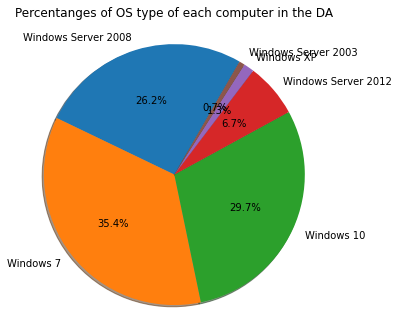

In [6]:
PC_OS['count'].plot.pie(autopct='%.1f%%',labels=PC_OS['OS_type'],
               shadow=True,fontsize=10,radius=1.5,startangle=60)
plt.title("Percentanges of OS type of each computer in the DA",y=1.2)
plt.ylabel('')
plt.show()

In [7]:
# The number of computers has a path to domian admin
computers_to_da = g.run("""
MATCH(PC:Computer), (B:Group{name:'DOMAIN ADMINS@TESTLAB.LOCAL'}),x = shortestPath((PC)-[*1..]->(B))
RETURN PC.name,LENGTH(x) as Path_length
ORDER BY LENGTH(x) ASC
""").to_data_frame()
computers_to_da

,PC.name,Path_length
0,COMP00025.TESTLAB.LOCAL,2
1,COMP00028.TESTLAB.LOCAL,2
2,COMP00037.TESTLAB.LOCAL,2
3,COMP00041.TESTLAB.LOCAL,2
4,COMP00058.TESTLAB.LOCAL,2
...,...,...
102,COMP00451.TESTLAB.LOCAL,7
103,COMP00532.TESTLAB.LOCAL,7
104,COMP00089.TESTLAB.LOCAL,8
105,COMP00391.TESTLAB.LOCAL,8


In [8]:
print("There are "+ str(computers_to_da.shape[0]) + " of computers have an attack path to the domain whcih is " 
      + str(round(computers_to_da.shape[0]/DA_info.loc['Computers'].item()*100,2)) + "% ")
print("There average length of attack path is " + str(round(computers_to_da["Path_length"].mean(),2)))

There are 107 of computers have an attack path to the domain whcih is 10.69% 
There average length of attack path is 3.9


# 3.Users

In [9]:
# The number of users has a path to domian admin
users_to_da = g.run("""
MATCH(account:User), (B:Group{name:'DOMAIN ADMINS@TESTLAB.LOCAL'}),x = shortestPath((account)-[*1..]->(B)) 
RETURN account.name,LENGTH(x) as Path_length
ORDER BY LENGTH(x) ASC
""").to_data_frame()
users_to_da

,account.name,Path_length
0,SHOLTZEN00926@TESTLAB.LOCAL,1
1,AWIDRIG00984@TESTLAB.LOCAL,1
2,IARGRO00987@TESTLAB.LOCAL,1
3,RRICKETT00036@TESTLAB.LOCAL,1
4,CLUNDBLAD00072@TESTLAB.LOCAL,1
...,...,...
90,CKIRCHNER00249@TESTLAB.LOCAL,6
91,BTREISCH00268@TESTLAB.LOCAL,6
92,NHUNTLEY00783@TESTLAB.LOCAL,6
93,AMCMURRAY00859@TESTLAB.LOCAL,7


In [10]:
print("There are "+ str(users_to_da.shape[0]) + " of users have an attack path to the domain whcih is " 
      + str(round(users_to_da.shape[0]/DA_info.loc['Users'].item()*100,2)) + "% ")
print("There average length of attack path is " + str(round(users_to_da["Path_length"].mean(),2)))

There are 95 of users have an attack path to the domain whcih is 9.49% 
There average length of attack path is 3.15


# 4.OUs

In [11]:
# The OU structure
OU_structure = g.run ("""
MATCH (n:OU)
OPTIONAL MATCH (n)-[:Contains]->(u:User)
OPTIONAL MATCH (n)-[:Contains]->(c:Computer)
OPTIONAL MATCH (n)-[:Contains]->(o:OU)
UNWIND n.name AS OU_name
RETURN OU_name, count(u) AS User_count,count(c) AS Computer_count,count(o) AS Sub_OU_count
""").to_data_frame()
OU_structure

,OU_name,User_count,Computer_count,Sub_OU_count
0,WA_COMPUTERS@TESTLAB.LOCAL,0,100,0
1,MD_COMPUTERS@TESTLAB.LOCAL,0,100,0
2,AL_COMPUTERS@TESTLAB.LOCAL,0,100,0
3,IN_COMPUTERS@TESTLAB.LOCAL,0,100,0
4,NV_COMPUTERS@TESTLAB.LOCAL,0,100,0
5,VA_COMPUTERS@TESTLAB.LOCAL,0,100,0
6,CA_COMPUTERS@TESTLAB.LOCAL,0,100,0
7,NY_COMPUTERS@TESTLAB.LOCAL,0,100,0
8,TX_COMPUTERS@TESTLAB.LOCAL,0,100,0
9,FL_COMPUTERS@TESTLAB.LOCAL,0,100,0


In [12]:
#Check if the same computer is contained in different OU
g.run ("""
MATCH (n:OU)-[:Contains]->(c:Computer)
WITH c, COLLECT({OU_name: n.name }) AS ou
WHERE SIZE(ou) > 1
RETURN c.name AS PC, ou;
""").to_data_frame()

""


In [13]:
#Check if the same User is contained in different OU
g.run ("""
MATCH (n:OU)-[:Contains]->(u:User)
WITH u, COLLECT({OU_name: n.name }) AS ou
WHERE SIZE(ou) > 1
RETURN u.name AS User, ou;
""").to_data_frame()

""


In [14]:
#Check if any User is not contained by a OU
g.run ("""
MATCH (u:User) WHERE not ((:OU)-[:Contains]->(u)) RETURN u.name AS User_name;
""").to_data_frame()

,User_name
0,HR00001@TESTLAB.LOCAL


In [15]:
#Check if any computer is not contained by a OU
g.run ("""
MATCH (c:Computer) WHERE not ((:OU)-[:Contains]->(c)) RETURN c.name AS Computer_name;
""").to_data_frame()

""


# 5.GPOs

In [16]:
# The GPO structure
GPO_structure = g.run ("""
MATCH (n:GPO)
MATCH (n)-[:GpLink]->(o:OU)
UNWIND n.name AS GPO_name
RETURN GPO_name,o.name AS linked_OU
""").to_data_frame()
GPO_data = GPO_structure.groupby('GPO_name')['linked_OU'].agg(list).reset_index()
pd.set_option('display.max_colwidth',100)
GPO_data

,GPO_name,linked_OU
0,DEFAULT DOMAIN CONTROLLERS POLICY@$domain,[DOMAIN CONTROLLERS@TESTLAB.LOCAL]
1,GPO_10@TESTLAB.LOCAL,"[WA_COMPUTERS@TESTLAB.LOCAL, IN_COMPUTERS@TESTLAB.LOCAL]"
2,GPO_11@TESTLAB.LOCAL,[IN_COMPUTERS@TESTLAB.LOCAL]
3,GPO_12@TESTLAB.LOCAL,"[IN_USERS@TESTLAB.LOCAL, NY_COMPUTERS@TESTLAB.LOCAL, NV_USERS@TESTLAB.LOCAL]"
4,GPO_13@TESTLAB.LOCAL,"[CA_USERS@TESTLAB.LOCAL, WA_COMPUTERS@TESTLAB.LOCAL, WA_USERS@TESTLAB.LOCAL]"
5,GPO_14@TESTLAB.LOCAL,"[IN_USERS@TESTLAB.LOCAL, CA_USERS@TESTLAB.LOCAL]"
6,GPO_15@TESTLAB.LOCAL,[FL_COMPUTERS@TESTLAB.LOCAL]
7,GPO_16@TESTLAB.LOCAL,[MD_USERS@TESTLAB.LOCAL]
8,GPO_17@TESTLAB.LOCAL,"[FL_USERS@TESTLAB.LOCAL, WA_COMPUTERS@TESTLAB.LOCAL]"
9,GPO_18@TESTLAB.LOCAL,"[TX_COMPUTERS@TESTLAB.LOCAL, NV_USERS@TESTLAB.LOCAL, WA_COMPUTERS@TESTLAB.LOCAL]"


In [17]:
#Check if the same OU is linked to different GPOs
g.run ("""
MATCH (n:GPO)-[:GpLink]->(o:OU)
WITH o, COLLECT({GPO_name: n.name }) AS gpo
WHERE SIZE(gpo) > 1
RETURN o.name AS OU_name, gpo AS Govered_GPO;
""").to_data_frame()

,OU_name,Govered_GPO
0,MD_USERS@TESTLAB.LOCAL,"[{'GPO_name': 'GPO_1@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_3@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_4@T..."
1,AL_USERS@TESTLAB.LOCAL,"[{'GPO_name': 'GPO_1@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_5@TESTLAB.LOCAL'}]"
2,TX_COMPUTERS@TESTLAB.LOCAL,"[{'GPO_name': 'GPO_2@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_7@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_18@..."
3,VA_COMPUTERS@TESTLAB.LOCAL,"[{'GPO_name': 'GPO_3@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_6@TESTLAB.LOCAL'}]"
4,NY_COMPUTERS@TESTLAB.LOCAL,"[{'GPO_name': 'GPO_3@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_7@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_12@..."
5,NV_USERS@TESTLAB.LOCAL,"[{'GPO_name': 'GPO_6@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_8@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_12@..."
6,WA_USERS@TESTLAB.LOCAL,"[{'GPO_name': 'GPO_7@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_13@TESTLAB.LOCAL'}]"
7,FL_USERS@TESTLAB.LOCAL,"[{'GPO_name': 'GPO_8@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_17@TESTLAB.LOCAL'}]"
8,WA_COMPUTERS@TESTLAB.LOCAL,"[{'GPO_name': 'GPO_8@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_10@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_13..."
9,IN_COMPUTERS@TESTLAB.LOCAL,"[{'GPO_name': 'GPO_10@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_11@TESTLAB.LOCAL'}, {'GPO_name': 'GPO_1..."


In [18]:
#The GPO that is linked to the domain
g.run ("""
MATCH (n:GPO)
MATCH (n)-[:GpLink]->(d:Domain)
RETURN d.name AS Domain,n.name AS Governed_GPO
""").to_data_frame()

,Domain,Governed_GPO
0,TESTLAB.LOCAL,DEFAULT DOMAIN POLICY@TESTLAB.LOCAL


In [19]:
#Check if any OU is not governed by a GPO
g.run ("""
MATCH (o:OU) WHERE not ((:GPO)-[:GpLink]->(o)) RETURN o.name AS OU_name;
""").to_data_frame()

,OU_name
0,MD_COMPUTERS@TESTLAB.LOCAL
1,AL_COMPUTERS@TESTLAB.LOCAL
2,NY_USERS@TESTLAB.LOCAL
3,TX_USERS@TESTLAB.LOCAL


In [20]:
#Check if any GPO is not linked to anything
g.run ("""
MATCH (g:GPO) WHERE not ((g)-[:GpLink]->()) RETURN g.name AS GPO_name;
""").to_data_frame()

,GPO_name
0,DEFAULT DOMAIN CONTROLLERS POLICY@TESTLAB.LOCAL


# 6.Groups

In [21]:
# The nested Group structure
Group_structure = g.run ("""
MATCH (n:Group)
MATCH (n)-[:MemberOf]->(G:Group)
UNWIND G.name AS Group_name
RETURN Group_name, n.name AS Sub_Group
""").to_data_frame()
Group_data = Group_structure.groupby('Group_name')['Sub_Group'].agg(list).reset_index()
pd.set_option('display.max_colwidth',100)
Group_data

,Group_name,Sub_Group
0,BIDNESS00017@TESTLAB.LOCAL,[BIDNESS00689@TESTLAB.LOCAL]
1,BIDNESS00020@TESTLAB.LOCAL,"[BIDNESS00633@TESTLAB.LOCAL, BIDNESS00884@TESTLAB.LOCAL]"
2,BIDNESS00028@TESTLAB.LOCAL,[BIDNESS00374@TESTLAB.LOCAL]
3,BIDNESS00032@TESTLAB.LOCAL,[BIDNESS00885@TESTLAB.LOCAL]
4,BIDNESS00037@TESTLAB.LOCAL,[BIDNESS00711@TESTLAB.LOCAL]
...,...,...
138,OPERATIONS00823@TESTLAB.LOCAL,[OPERATIONS00395@TESTLAB.LOCAL]
139,OPERATIONS00924@TESTLAB.LOCAL,[OPERATIONS00947@TESTLAB.LOCAL]
140,OPERATIONS00936@TESTLAB.LOCAL,[OPERATIONS00940@TESTLAB.LOCAL]
141,OPERATIONS00940@TESTLAB.LOCAL,[OPERATIONS00253@TESTLAB.LOCAL]


In [22]:
#Check if the same computer is a memeber of different group
g.run ("""
MATCH (c:computer)-[:MemberOf]->(n:Group)
WITH c, COLLECT({Group_name: n.name }) AS Group
WHERE SIZE(Group) > 1
RETURN c.name AS PC, Group;
""").to_data_frame()

""


In [23]:
#Check if the same user is memeber of different group
nested_user = g.run ("""
MATCH (u:User)-[:MemberOf]->(n:Group)
WITH u, COLLECT({Group_name: n.name }) AS Group
WHERE SIZE(Group) > 1
RETURN u.name AS User, Group;
""").to_data_frame()
pd.set_option('display.max_colwidth',1000)
nested_user

,User,Group
0,DPAULIN00857@TESTLAB.LOCAL,"[{'Group_name': 'HR00920@TESTLAB.LOCAL'}, {'Group_name': 'HR00144@TESTLAB.LOCAL'}, {'Group_name': 'HR00521@TESTLAB.LOCAL'}, {'Group_name': 'HR00929@TESTLAB.LOCAL'}, {'Group_name': 'HR00080@TESTLAB.LOCAL'}, {'Group_name': 'HR00573@TESTLAB.LOCAL'}, {'Group_name': 'HR00161@TESTLAB.LOCAL'}, {'Group_name': 'DOMAIN USERS@TESTLAB.LOCAL'}]"
1,ELASCOLA00858@TESTLAB.LOCAL,"[{'Group_name': 'BIDNESS00705@TESTLAB.LOCAL'}, {'Group_name': 'BIDNESS00782@TESTLAB.LOCAL'}, {'Group_name': 'BIDNESS00709@TESTLAB.LOCAL'}, {'Group_name': 'BIDNESS00855@TESTLAB.LOCAL'}, {'Group_name': 'BIDNESS00177@TESTLAB.LOCAL'}, {'Group_name': 'BIDNESS00971@TESTLAB.LOCAL'}, {'Group_name': 'BIDNESS00699@TESTLAB.LOCAL'}, {'Group_name': 'BIDNESS00722@TESTLAB.LOCAL'}, {'Group_name': 'DOMAIN USERS@TESTLAB.LOCAL'}]"
2,AMCMURRAY00859@TESTLAB.LOCAL,"[{'Group_name': 'IT00266@TESTLAB.LOCAL'}, {'Group_name': 'IT00394@TESTLAB.LOCAL'}, {'Group_name': 'IT00808@TESTLAB.LOCAL'}, {'Group_name': 'DOMAIN USERS@TESTLAB.LOCAL'}]"
3,NKASEL00860@TESTLAB.LOCAL,"[{'Group_name': 'OPERATIONS00617@TESTLAB.LOCAL'}, {'Group_name': 'OPERATIONS00157@TESTLAB.LOCAL'}, {'Group_name': 'OPERATIONS00182@TESTLAB.LOCAL'}, {'Group_name': 'OPERATIONS00861@TESTLAB.LOCAL'}, {'Group_name': 'OPERATIONS00068@TESTLAB.LOCAL'}, {'Group_name': 'OPERATIONS00093@TESTLAB.LOCAL'}, {'Group_name': 'OPERATIONS00465@TESTLAB.LOCAL'}, {'Group_name': 'DOMAIN USERS@TESTLAB.LOCAL'}]"
4,HBORELLI00861@TESTLAB.LOCAL,"[{'Group_name': 'MARKETING00655@TESTLAB.LOCAL'}, {'Group_name': 'MARKETING00759@TESTLAB.LOCAL'}, {'Group_name': 'MARKETING00478@TESTLAB.LOCAL'}, {'Group_name': 'DOMAIN USERS@TESTLAB.LOCAL'}]"
...,...,...
995,DLEMOINE00852@TESTLAB.LOCAL,"[{'Group_name': 'OPERATIONS00614@TESTLAB.LOCAL'}, {'Group_name': 'OPERATIONS00277@TESTLAB.LOCAL'}, {'Group_name': 'OPERATIONS00958@TESTLAB.LOCAL'}, {'Group_name': 'DOMAIN USERS@TESTLAB.LOCAL'}]"
996,LKULAGA00853@TESTLAB.LOCAL,"[{'Group_name': 'HR00629@TESTLAB.LOCAL'}, {'Group_name': 'HR00954@TESTLAB.LOCAL'}, {'Group_name': 'HR00449@TESTLAB.LOCAL'}, {'Group_name': 'HR00089@TESTLAB.LOCAL'}, {'Group_name': 'HR00521@TESTLAB.LOCAL'}, {'Group_name': 'HR00095@TESTLAB.LOCAL'}, {'Group_name': 'DOMAIN USERS@TESTLAB.LOCAL'}]"
997,HCONFORME00854@TESTLAB.LOCAL,"[{'Group_name': 'HR00083@TESTLAB.LOCAL'}, {'Group_name': 'HR00543@TESTLAB.LOCAL'}, {'Group_name': 'HR00817@TESTLAB.LOCAL'}, {'Group_name': 'HR00830@TESTLAB.LOCAL'}, {'Group_name': 'HR00566@TESTLAB.LOCAL'}, {'Group_name': 'HR00916@TESTLAB.LOCAL'}, {'Group_name': 'HR00049@TESTLAB.LOCAL'}, {'Group_name': 'DOMAIN USERS@TESTLAB.LOCAL'}]"
998,SWILLGING00855@TESTLAB.LOCAL,"[{'Group_name': 'OPERATIONS00193@TESTLAB.LOCAL'}, {'Group_name': 'OPERATIONS00019@TESTLAB.LOCAL'}, {'Group_name': 'OPERATIONS00219@TESTLAB.LOCAL'}, {'Group_name': 'DOMAIN USERS@TESTLAB.LOCAL'}]"


In [24]:
# number of users in each group
g.run ("""
MATCH (u:User)-[:MemberOf]->(n:Group)
UNWIND n.name AS Group_name
RETURN Group_name, COUNT(DISTINCT(u)) AS number_of_users
ORDER BY COUNT(DISTINCT(u)) DESC
""").to_data_frame()

,Group_name,number_of_users
0,DOMAIN USERS@TESTLAB.LOCAL,1000
1,DOMAIN ADMINS@TESTLAB.LOCAL,30
2,HR00954@TESTLAB.LOCAL,13
3,HR00932@TESTLAB.LOCAL,13
4,BIDNESS00412@TESTLAB.LOCAL,13
...,...,...
994,MARKETING00882@TESTLAB.LOCAL,1
995,MARKETING00965@TESTLAB.LOCAL,1
996,MARKETING00894@TESTLAB.LOCAL,1
997,MARKETING00036@TESTLAB.LOCAL,1


In [25]:
# number of PCs in each group
g.run ("""
MATCH (c:Computer)-[:MemberOf]->(n:Group)
UNWIND n.name AS Group_name
RETURN Group_name, COUNT(DISTINCT(c)) AS number_of_PC
ORDER BY COUNT(DISTINCT(c)) DESC
""").to_data_frame()

,Group_name,number_of_PC
0,DOMAIN COMPUTERS@TESTLAB.LOCAL,1000
1,ENTERPRISE DOMAIN CONTROLLERS@TESTLAB.LOCAL,1
2,DOMAIN CONTROLLERS@TESTLAB.LOCAL,1


In [26]:
#Check if there is any empty group
g.run ("""
MATCH (n:Group) WHERE not (()-[:MemberOf]->(n)) RETURN n.name; 
""").to_data_frame()

,n.name
0,HR00142@TESTLAB.LOCAL
1,OPERATIONS00490@TESTLAB.LOCAL
2,MARKETING00681@TESTLAB.LOCAL
3,ENTERPRISE READ-ONLY DOMAIN CONTROLLERS@TESTLAB.LOCAL
4,ADMINISTRATORS@TESTLAB.LOCAL
5,ENTERPRISE ADMINS@TESTLAB.LOCAL


# 7. Kerberoastable users
This part of code is mainly modified from https://medium.com/threat-hunters-forge/jupyter-notebooks-for-bloodhound-analytics-and-alternative-visualizations-9543c2df576a

In [27]:
sg_computers_df = g.run("""
MATCH (g:Group)
OPTIONAL MATCH (g)-[:AdminTo]->(c1:Computer)
OPTIONAL MATCH (g)-[:MemberOf*1..]->(:Group)-[:AdminTo]->(c2:Computer)
WITH g, COLLECT(c1) + COLLECT(c2) AS tempVar
UNWIND tempVar AS computers
RETURN g.name AS GroupName,COUNT(DISTINCT(computers)) AS AdminRightCount
ORDER BY AdminRightCount DESC
""").to_data_frame()
sg_computers_df

,GroupName,AdminRightCount
0,DOMAIN ADMINS@TESTLAB.LOCAL,1001
1,IT00582@TESTLAB.LOCAL,851
2,IT00153@TESTLAB.LOCAL,850
3,IT00194@TESTLAB.LOCAL,850
4,IT00289@TESTLAB.LOCAL,850
...,...,...
67,IT00864@TESTLAB.LOCAL,1
68,IT00879@TESTLAB.LOCAL,1
69,IT00918@TESTLAB.LOCAL,1
70,IT00937@TESTLAB.LOCAL,1


In [28]:
#Count number of Kerberoastable Users 
users_hasspn_count = g.run("""
MATCH (u:User {hasspn:true})
RETURN COUNT(u) AS Count
""").to_data_frame()
users_hasspn_count

,Count
0,11


In [29]:
#Name of Kerberoastable Users 
g.run("""
MATCH (u:User {hasspn:true})
RETURN u.name AS User_name
""").to_data_frame()

,User_name
0,PEXTINE00939@TESTLAB.LOCAL
1,CLUNDBLAD00072@TESTLAB.LOCAL
2,CMELLENCAMP00100@TESTLAB.LOCAL
3,NTOREY00313@TESTLAB.LOCAL
4,WBELLOW00324@TESTLAB.LOCAL
5,TKAHOLA00335@TESTLAB.LOCAL
6,TFARA00341@TESTLAB.LOCAL
7,TBRASBY00546@TESTLAB.LOCAL
8,EANNALA00559@TESTLAB.LOCAL
9,TKUNDE00693@TESTLAB.LOCAL


In [30]:
# The path length of Kerberoastable Users  to domain admin
krb_users_path_to_DA = g.run("""
MATCH (u:User {hasspn:true})
MATCH (g:Group {name:'DOMAIN ADMINS@TESTLAB.LOCAL'})
MATCH p = shortestPath(
  (u)-[*1..]->(g)
)
RETURN u.name,LENGTH(p) AS Path_length
ORDER BY LENGTH(p) ASC
""").to_data_frame()
krb_users_path_to_DA

,u.name,Path_length
0,CLUNDBLAD00072@TESTLAB.LOCAL,1
1,TKAHOLA00335@TESTLAB.LOCAL,1
2,TFARA00341@TESTLAB.LOCAL,1
3,TBRASBY00546@TESTLAB.LOCAL,1
4,EANNALA00559@TESTLAB.LOCAL,1
5,HMINCKLER00716@TESTLAB.LOCAL,1
6,PEXTINE00939@TESTLAB.LOCAL,3
7,NTOREY00313@TESTLAB.LOCAL,3
8,WBELLOW00324@TESTLAB.LOCAL,3
9,TKUNDE00693@TESTLAB.LOCAL,3


In [31]:
# Number of Most Privileged Kerberoastable users based on how many computers they have local admins rights on.
privileged_kerberoastable_users = g.run("""
MATCH (u:User {hasspn:true})
OPTIONAL MATCH (u)-[:AdminTo]->(c1:Computer)
OPTIONAL MATCH (u)-[:MemberOf*1..]->(:Group)-[:AdminTo]->(c2:Computer)
WITH u,COLLECT(c1) + COLLECT(c2) AS tempVar
UNWIND tempVar AS comps
RETURN u.name,COUNT(DISTINCT(comps)) AS num_of_PCs
ORDER BY COUNT(DISTINCT(comps)) DESC
""").to_data_frame()
privileged_kerberoastable_users

,u.name,num_of_PCs
0,CLUNDBLAD00072@TESTLAB.LOCAL,1001
1,TKAHOLA00335@TESTLAB.LOCAL,1001
2,TFARA00341@TESTLAB.LOCAL,1001
3,TBRASBY00546@TESTLAB.LOCAL,1001
4,EANNALA00559@TESTLAB.LOCAL,1001
5,HMINCKLER00716@TESTLAB.LOCAL,1001
6,WBELLOW00324@TESTLAB.LOCAL,38
7,CMELLENCAMP00100@TESTLAB.LOCAL,23
8,PEXTINE00939@TESTLAB.LOCAL,17
9,NTOREY00313@TESTLAB.LOCAL,13
